# Decision Tree Model Training

This notebook trains the Decision Tree classifier used to distinguish high-confidence functional motifs from background regex matches based on AlphaMissense pathogenicity scores.

**Logic:**

- **Class 1 (Positive):** Known ELM instances (experimentally validated).
- **Class 0 (Negative):** Predicted regex matches (background).

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import joblib
from tqdm import tqdm

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.config import PROCESSED_DATA_DIR, FIGURES_DIR

# 1. Load Data

We load the processed datasets containing AlphaMissense features for Known and Predicted motifs.


In [2]:
# Define paths (Adjust these if you placed files elsewhere)
TRAIN_DATA_DIR = os.path.join(PROCESSED_DATA_DIR) # Or 'training_data' if you made a subfolder

path_known = os.path.join(TRAIN_DATA_DIR, "elm_known_with_am_info_all_disorder_class_filtered.tsv")
path_predicted = os.path.join(TRAIN_DATA_DIR, "elm_predicted_with_am_info_all_disorder_class_filtered.tsv")

if not os.path.exists(path_known) or not os.path.exists(path_predicted):
    raise FileNotFoundError(f"Please copy the training files to {TRAIN_DATA_DIR}")

print("Loading data...")
df_known = pd.read_csv(path_known, sep='\t')
df_predicted = pd.read_csv(path_predicted, sep='\t')

# Labeling
df_known['known'] = True
df_predicted['known'] = False

print(f"Known (Positive): {len(df_known)}")
print(f"Predicted (Negative): {len(df_predicted)}")

Loading data...
Known (Positive): 1643
Predicted (Negative): 1144878


## 2. Preprocessing & Feature Engineering

We need to calculate the derived features used by the model:
* `AM_Max`: Maximum score in the motif (parsed from string list if necessary).
* `Key_vs_NonKey_Difference`: Key Mean - Flanking Mean.
* `Motif_vs_Sequential_Difference`: Motif Mean - Sequential Mean.

In [3]:
def preprocess_df(df):
    df = df.copy()

    # 1. Parse AM_Max (CRITICAL STEP)
    # The old script parsed 'motif_am_scores' string to find max.
    if 'motif_am_scores' in df.columns:
        print("Parsing 'motif_am_scores' column...")
        df['AM_Max'] = df['motif_am_scores'].apply(
            lambda x: max(map(float, x.split(', '))) if isinstance(x, str) else (x if isinstance(x, (int, float)) and not pd.isna(x) else np.nan)
        )
    elif 'AM_Max' not in df.columns:
        print("Warning: Neither 'motif_am_scores' nor 'AM_Max' found. Filling AM_Max with 0.")
        df['AM_Max'] = 0

    # 2. Calculate Differences (Feature Engineering)
    # Ensure numeric types
    cols = ['key_residue_am_mean_score', 'flanking_residue_am_mean_score',
            'motif_am_mean_score', 'sequential_am_score']
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    df['Key_vs_NonKey_Difference'] = df['key_residue_am_mean_score'] - df['flanking_residue_am_mean_score']
    df['Motif_vs_Sequential_Difference'] = df['motif_am_mean_score'] - df['sequential_am_score']

    return df

# Combine and Process
print("Concatenating datasets...")
df_full = pd.concat([df_predicted, df_known], ignore_index=True)

print("Running preprocessing...")
df_full = preprocess_df(df_full)

# Define Features (Exact columns from old script)
metrics_cols = [
    'motif_am_mean_score',
    'key_residue_am_mean_score',
    'flanking_residue_am_mean_score',
    'sequential_am_score',
    'Key_vs_NonKey_Difference',
    'Motif_vs_Sequential_Difference',
    'AM_Max'
]

# Drop NaNs based on features (Old script: dropna(subset=use_cols))
print(f"Original size: {len(df_full)}")
df_clean = df_full.dropna(subset=metrics_cols).copy()
print(f"Data after dropping NaNs: {len(df_clean)}")

# Prepare X and y
X = df_clean[metrics_cols].to_numpy()
y = df_clean['known'].astype(int).values # True->1, False->0

# Indices for bootstrapping
idx_pos = np.where(y == 1)[0]
idx_neg = np.where(y == 0)[0]

print(f"Final Positives: {len(idx_pos)}")
print(f"Final Negatives: {len(idx_neg)}")

Concatenating datasets...
Running preprocessing...
Parsing 'motif_am_scores' column...
Original size: 1146521
Data after dropping NaNs: 1108375
Final Positives: 1526
Final Negatives: 1106849


## 3. Model Initialization

We use a **Decision Tree** with `class_weight='balanced'` to handle the imbalance between Known (few) and Predicted (many).

In [4]:
clf = tree.DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    class_weight='balanced',
    ccp_alpha=0.005 # Pruning parameter
)

## 4. Cross-Validation (Bootstrap)

Since the negative set is much larger, we perform a bootstrap validation where we sample Negatives to match the number of Positives in each iteration to verify stability.

Running 100 bootstrap iterations with 10-fold CV...


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]



Mean Accuracy: 0.750 ± 0.039


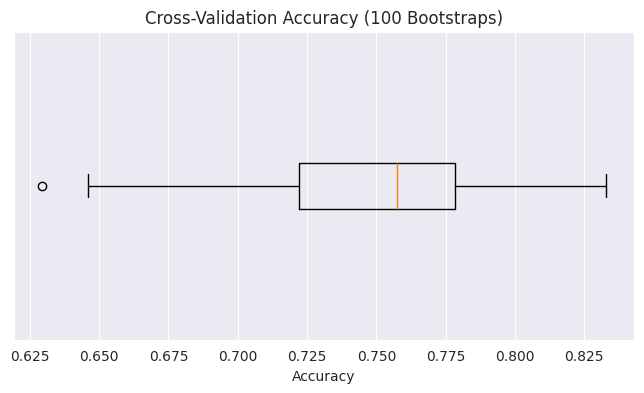

In [5]:
cv_folds = 10
n_bootstrap = 100
all_scores = []

print(f"Running {n_bootstrap} bootstrap iterations with {cv_folds}-fold CV...")

for i in tqdm(range(n_bootstrap)):
    # Downsample Negatives to match Positives count
    sampled_neg = np.random.choice(idx_neg, size=len(idx_pos), replace=False)
    sampled_indices = np.concatenate([idx_pos, sampled_neg])

    X_sample = X[sampled_indices]
    y_sample = y[sampled_indices]

    # CV Score
    scores = cross_val_score(clf, X_sample, y_sample, cv=cv_folds, scoring='accuracy')
    all_scores.extend(scores)

mean_acc = np.mean(all_scores)
std_acc = np.std(all_scores)

print(f"\nMean Accuracy: {mean_acc:.3f} ± {std_acc:.3f}")

# Plot Accuracy Distribution
plt.figure(figsize=(8, 4))
plt.boxplot(all_scores, vert=False)
plt.title(f"Cross-Validation Accuracy ({n_bootstrap} Bootstraps)")
plt.xlabel("Accuracy")
plt.yticks([])
plt.show()

## 5. Train Final Model

We train the model on the **full dataset** (using class weights to handle imbalance) and evaluate it.

10-fold CV Accuracy: 0.815 ± 0.055
Training final model...


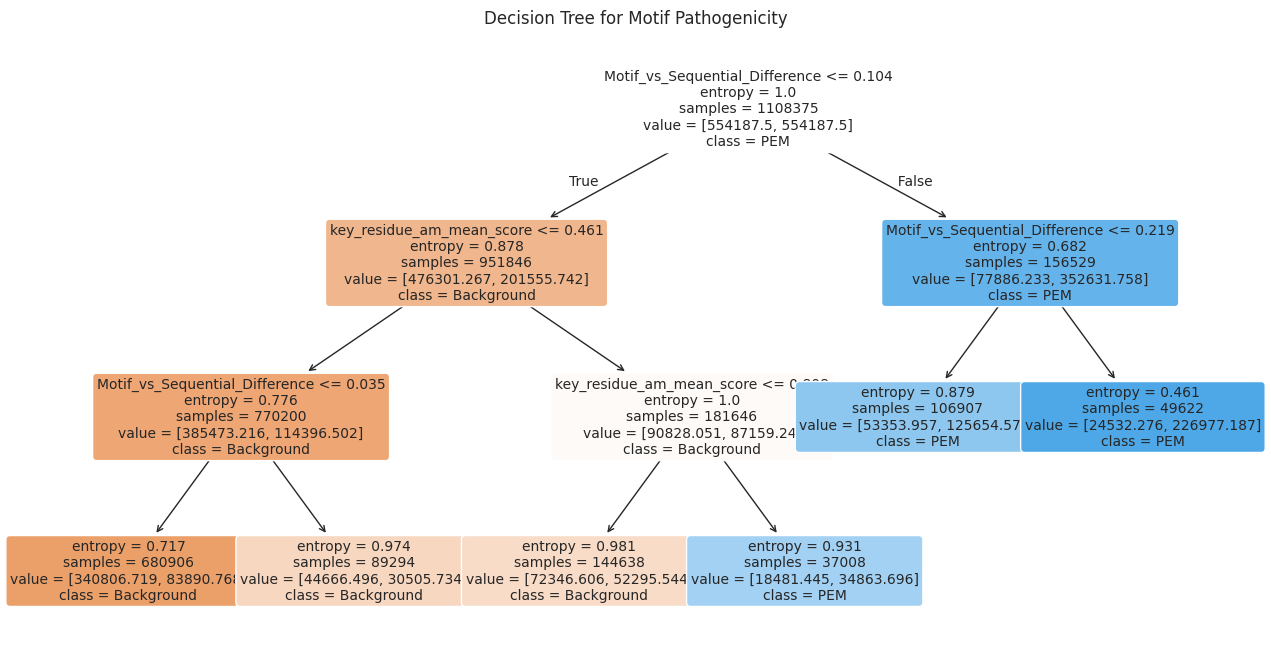

In [6]:
# Train

# Cross-Validation Check (Optional)
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print(f"10-fold CV Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# Train Final Model on FULL Data
print("Training final model...")
clf.fit(X, y)

# Visual check of the tree
plt.figure(figsize=(16, 8))
tree.plot_tree(
    clf,
    filled=True,
    feature_names=metrics_cols,
    class_names=['Background', 'PEM'],
    fontsize=10,
    rounded=True
)
plt.title("Decision Tree for Motif Pathogenicity")
plt.show()


## 6. Visualize Tree

Visualizing the decision rules.

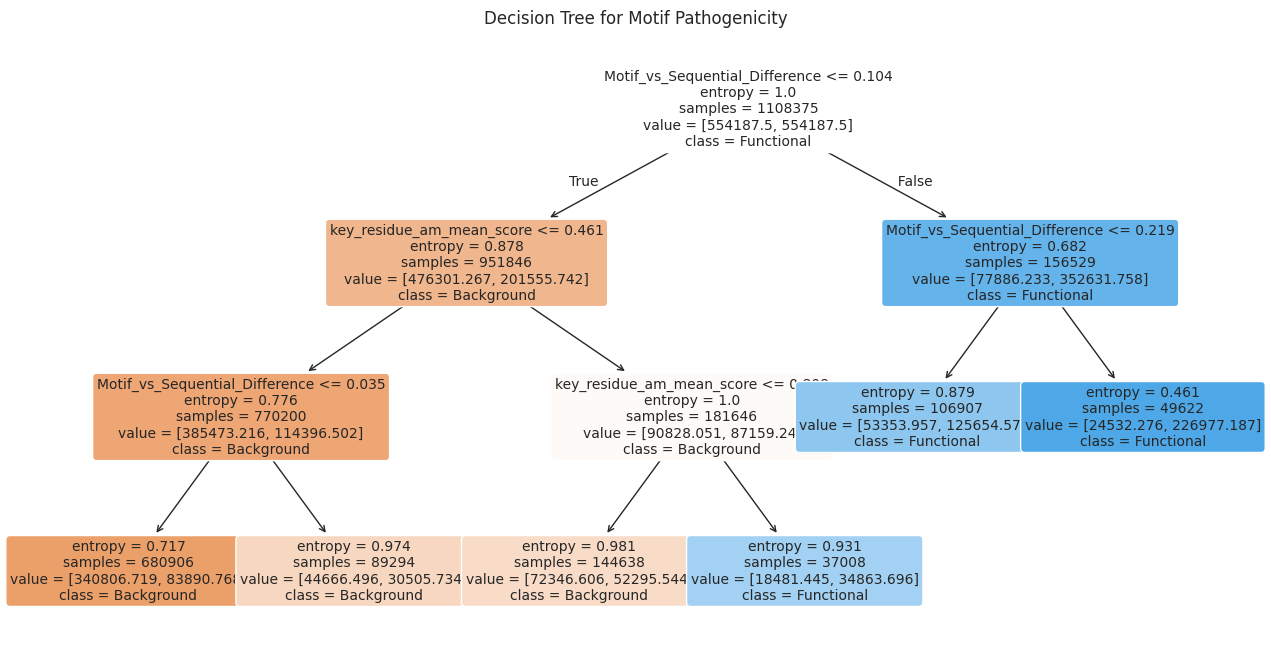

In [7]:
plt.figure(figsize=(16, 8))
tree.plot_tree(
    clf,
    filled=True,
    feature_names=metrics_cols,
    class_names=['Background', 'Functional'],
    fontsize=10,
    rounded=True
)
plt.title("Decision Tree for Motif Pathogenicity")
plt.show()

## 7. Save Model
Saving the trained model to `data/processed/models/` so it can be used by the prediction pipeline.


In [8]:
save_dir = os.path.join(PROCESSED_DATA_DIR, "models")
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "decision_tree_v1.pkl")

joblib.dump(clf, model_path)
relative_path = os.path.relpath(model_path, project_root)
print(f"Model saved successfully to: {relative_path}")


Model saved successfully to: data/processed/models/decision_tree_v1.pkl
